## Ravelin Data Science Test
#### by Nathan Cheng

Install package to interpret the IP address data

In [371]:
!pip install geoip2

Importing the packages I will be using

 - Note: I have downloaded geolite2 databases to analyze the IP addresses

In [401]:
# Import packages that will be used

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json
from pandas.io.json import json_normalize
import seaborn as sns
import matplotlib.pyplot as plt
import string

plt.rcParams.update({'font.size':12})

import geoip2.database

import category_encoders as ce
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.utils.multiclass import unique_labels

# Suppress some warnings
import warnings
warnings.simplefilter(action='ignore',category=FutureWarning)
warnings.simplefilter(action='ignore',category=UserWarning)


import os
print(os.listdir("../input"))

['geolite2dataset', 'geolite2city', 'ravelin-data-science-test']


Importing the JSON dataset into a Pandas DataFrame

In [373]:
# Import the data

d = []
with open('../input/ravelin-data-science-test/customers.json') as f:
    for line in f:
        d.append(json.loads(line))
df_init = pd.DataFrame(d)
print(len(df_init))
df_init.head(5)

168


,customer,fraudulent,orders,paymentMethods,transactions
0,"{'customerEmail': 'josephhoward@yahoo.com', 'c...",False,"[{'orderId': 'vjbdvd', 'orderAmount': 18, 'ord...","[{'paymentMethodId': 'wt07xm68b', 'paymentMeth...","[{'transactionId': 'a9lcj51r', 'orderId': 'vjb..."
1,"{'customerEmail': 'evansjeffery@yahoo.com', 'c...",True,"[{'orderId': 'nlghpa', 'orderAmount': 45, 'ord...","[{'paymentMethodId': 'y3xp697jx', 'paymentMeth...","[{'transactionId': '5mi94sfw', 'orderId': 'nlg..."
2,"{'customerEmail': 'andersonwilliam@yahoo.com',...",False,"[{'orderId': 'yk34y2', 'orderAmount': 33, 'ord...","[{'paymentMethodId': '8pneoi03z', 'paymentMeth...","[{'transactionId': 'q3lyvbza', 'orderId': 'yk3..."
3,"{'customerEmail': 'rubenjuarez@yahoo.com', 'cu...",False,"[{'orderId': 'fbz9ep', 'orderAmount': 34, 'ord...","[{'paymentMethodId': 'pdxjdwui4', 'paymentMeth...","[{'transactionId': 'vx4cjc27', 'orderId': 'fbz..."
4,"{'customerEmail': 'uchen@malone.com', 'custome...",True,"[{'orderId': '56h7iw', 'orderAmount': 71, 'ord...","[{'paymentMethodId': 'w1i1zq3rg', 'paymentMeth...","[{'transactionId': 'q8j3dgni', 'orderId': '56h..."


## Purpose and Design

The dataset must be decomposed for analysis.  
This could be done a number of ways.  
The method implemented in the following is:  
 - The transactions will be decomposed and linked to the customer, order and payment method.
 - Each transaction will be used to predict whether or not the transaction (and therefore customer) is fraudulent
 - This will limit us in that we will not be able to access information regarding the number of transactions a customer performs, however it does have the benefit of not explicitly requiring multiple transactions to improve the model, although this may still be implicitly utilized.

In [374]:
# Unwrap Nested JSON data
#
# Roughly a 2:1 ratio of false to true fraudulent data labels
# We will use each transaction to determine whether a customer is fraudulent
# Each transaction has an orderId and paymentMethodId, which point to a paymentMethod and order

# First we make separate DataFrames of the orders and paymentMethods
df_orders = pd.concat([pd.DataFrame(json_normalize(x)) for x in df_init['orders']],ignore_index=True)
df_paymentMethods = pd.concat([pd.DataFrame(json_normalize(x)) for x in df_init['paymentMethods']],ignore_index=True)

# Secondly we make a joint DataFrame of the transactions and customer
df = json_normalize(d,['transactions'],['customer','fraudulent'])
df = pd.concat([json_normalize(df['customer']),df],axis=1).drop(columns='customer')

print("initial length:", len(df))

# Now we need to add the paymentMethod and order info to each transaction
df = pd.merge(df,df_orders,on='orderId')
df = pd.merge(df,df_paymentMethods,on='paymentMethodId')

# Drop the unique Id identifiers since these won't be useful features for a model
df = df.drop(columns=['orderId','paymentMethodId','transactionId'])

# Also drop customerDevice, since this appears to be a unique customer identifier as well
df = df.drop(columns='customerDevice')

# Check to see if there were any unmatched Ids
print("inner-join length: ", len(df))

df.head()

initial length: 623
inner-join length:  623


,customerBillingAddress,customerEmail,customerIPAddress,customerPhone,transactionAmount,transactionFailed,fraudulent,orderAmount,orderShippingAddress,orderState,paymentMethodIssuer,paymentMethodProvider,paymentMethodRegistrationFailure,paymentMethodType
0,"5493 Jones Islands\nBrownside, CA 51896",josephhoward@yahoo.com,8.129.104.40,400-108-5415,18,False,False,18,"5493 Jones Islands\nBrownside, CA 51896",pending,Citizens First Banks,JCB 16 digit,True,card
1,"5493 Jones Islands\nBrownside, CA 51896",josephhoward@yahoo.com,8.129.104.40,400-108-5415,26,False,False,26,"5493 Jones Islands\nBrownside, CA 51896",fulfilled,Citizens First Banks,JCB 16 digit,True,card
2,356 Elizabeth Inlet Suite 120\nPort Joshuabury...,evansjeffery@yahoo.com,219.173.211.202,1-788-091-7546,45,False,True,45,"898 Henry Ports\nNew Keithview, CA 95893-2497",fulfilled,Bastion Banks,American Express,False,bitcoin
3,356 Elizabeth Inlet Suite 120\nPort Joshuabury...,evansjeffery@yahoo.com,219.173.211.202,1-788-091-7546,23,False,True,23,356 Elizabeth Inlet Suite 120\nPort Joshuabury...,fulfilled,Bastion Banks,American Express,False,bitcoin
4,356 Elizabeth Inlet Suite 120\nPort Joshuabury...,evansjeffery@yahoo.com,219.173.211.202,1-788-091-7546,43,True,True,43,"5093 Bryan Forks\nJoshuaton, FM 01565-9801",fulfilled,Solace Banks,VISA 16 digit,True,bitcoin


The dataset is skewed towards legitimate transactions, however not nearly to the extent, as one would expect.  
This will help the model learn more easily. 

In [375]:
# How many fraudulent transactions are there?

print('Fraudulent transactions: ', df[df['fraudulent']==True]['orderState'].count())
print('Non-fraudulent transactions: ', df[df['fraudulent']==False]['orderState'].count())

Fraudulent transactions:  257
Non-fraudulent transactions:  366


### Preliminary Data Visualization

First we visualize some of the readily available features of the data.  
  
Some interesting features that can be seen in the figures:  
 - The payment method issuer field has single character values that indicate a fraudulent transaction.
 - Large order and transaction amounts (>50) also indicate fraudulence. 
 - The other features are all correlated to varying, lesser degrees.

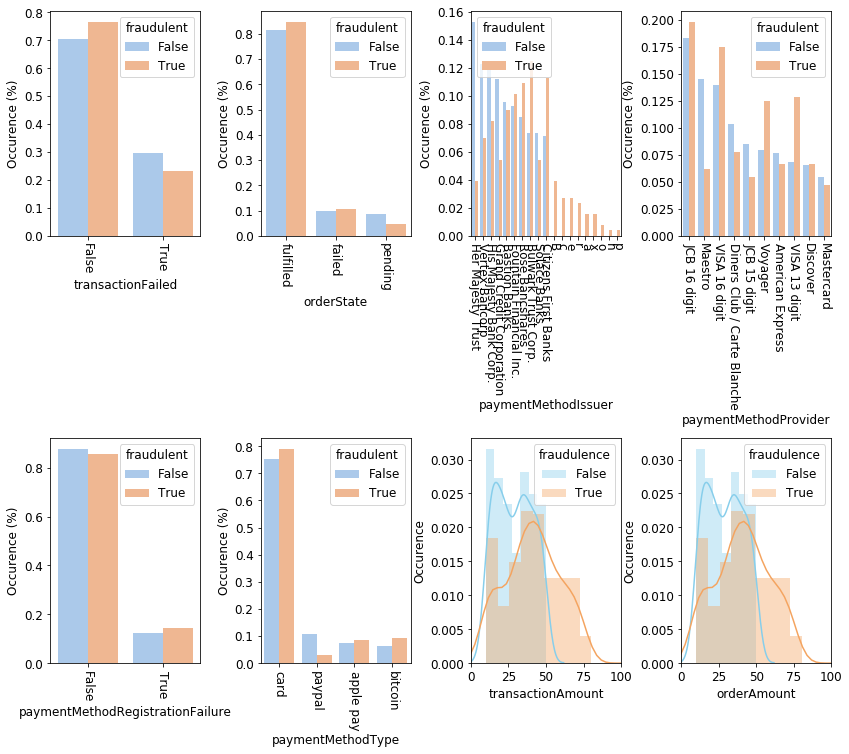

In [376]:
# Data Visualization/Exploration
#
# Our data is (surprisingly) not very skewed towards non-fraudulent transactions
# 
# Let's visualize some of our data features and see how well they can predict fraud

# Function to extract the value_counts() of different features when fraudulent = True or False
def fraudLabelComp(feature,dataFrame):
    temp = dataFrame.groupby('fraudulent')[feature].value_counts(normalize=True)
    temp = pd.DataFrame(temp)
    temp = pd.DataFrame(pd.DataFrame(temp).stack()).reset_index()
    temp = temp.drop(temp.columns[2], axis=1)
    temp = temp.rename(columns={temp.columns[2]:'value'})
    return temp

# Apply our function to features with labels
tf = fraudLabelComp('transactionFailed',df)
os = fraudLabelComp('orderState',df)
pmi = fraudLabelComp('paymentMethodIssuer',df)
pmp = fraudLabelComp('paymentMethodProvider',df)
pmrf = fraudLabelComp('paymentMethodRegistrationFailure',df)
pmt = fraudLabelComp('paymentMethodType',df)

# Function to plot the value_counts() of different labeled features when fraudulent = True or False
def fraudLabelPlot(featureData,x,y):
    plot = sns.barplot(x = featureData.columns[1], y=featureData.columns[2], hue=featureData.columns[0], palette='pastel',data = featureData,ax=axes[x,y])
    plot.set(xlabel = featureData.columns[1],ylabel = 'Occurence (%)')
    plot.set_xticklabels(plot.get_xticklabels(),rotation=-90)
    return;

# Function to plot the distribution of different numerical features when fraudulent = True or False
def fraudNumPlot(feature,x,y):
    plot = sns.distplot(df[df['fraudulent']==False][feature],color='skyblue', label = 'False', ax=axes[x,y])
    plot = sns.distplot(df[df['fraudulent']==True][feature],color='sandybrown', label = 'True', ax=axes[x,y])
    plot.set(xlabel = feature,ylabel = 'Occurence')
    plot.legend(title = 'fraudulence')
    axes[x,y].set_xlim(0,100)

    return;

# Make the plot of categorical/numerical features
fig,axes = plt.subplots(2,4,figsize=(14,12))

fraudLabelPlot(tf,0,0)
fraudLabelPlot(os,0,1)
fraudLabelPlot(pmi,0,2)
fraudLabelPlot(pmp,0,3)
fraudLabelPlot(pmrf,1,0)
fraudLabelPlot(pmt,1,1)

fraudNumPlot('transactionAmount',1,2)
fraudNumPlot('orderAmount',1,3)

plt.subplots_adjust(hspace=0.9)
plt.subplots_adjust(wspace=0.4)
plt.show()

In [377]:
# Are the transactionAmount and orderAmount fields equal?
df['transactionAmount'].equals(df['orderAmount'])

True

In [378]:
# Since the single character paymentMethodIssuer all result in fraudulent customers, we will change these to a common label
df['paymentMethodIssuer'] = df['paymentMethodIssuer'].apply(lambda x: x if len(x)>1 else 'f')

# where f stands for fraudulent issuer

## Feature Engineering
  
The following features will be extracted from the IP, email, phone and address features.
- IP
    1. Continent
    2. Country
    3. City
    4. Postal Code
    5. Longitude
    6. Lattitude
- Email
    1. Number of digits
    2. Top level domain
    3. Lower level domain
    4. Number of characters
- Phone
    1. If it has an extension
    2. Area Code
    3. Country Code
    4. Number of digits
- Address
    1. Whether the shipping and billing address are equal
    2. The state

There are no doubt other features to extract, but this will be a starting point.

In [379]:
# IP address data extraction
#
# Lots of information can be extracted from the IP address
# We will only examine a bit so as to not exceed the scope of this project

# get the IP data
reader = geoip2.database.Reader('../input/geolite2city/GeoLite2-City.mmdb')
reader2 = geoip2.database.Reader('../input/geolite2dataset/GeoLite2-Country.mmdb')
# Function to get the country from IP address if in DB
#
# Note: DB says it supports ipv6, but it doesn't find many countries for ipv6
def getCountry(x):
    try: 
        response = reader.city(x)
        name = response.country.iso_code
    except:
        name = "Not in DB"
    return name

def getCountry2(x):
    try: 
        response = reader2.country(x)
        name = response.country.iso_code
    except:
        name = "Not in DB"
    return name

def getCity(x):
    try: 
        response = reader.city(x)
        name = response.city.geoname_id
    except:
        name = "Not in DB"
    return name

def getPostalCode(x):
    try: 
        response = reader.city(x)
        name = response.postal.code
    except:
        name = "Not in DB"
    return name

def getLat(x):
    try: 
        response = reader.city(x)
        name = response.location.latitude
    except:
        name = "Not in DB"
    return name

def getLong(x):
    try: 
        response = reader.city(x)
        name = response.location.longitude
    except:
        name = "Not in DB"
    return name

def getContinent(x):
    try: 
        response = reader.city(x)
        name = response.continent.code
    except:
        name = "Not in DB"
    return name

# # First let's make a DataFrame for IP features
iP = pd.DataFrame()

# get IP country city postal code features
iP['country'] = df['customerIPAddress'].apply(lambda x: getCountry(x))
iP['continent'] = df['customerIPAddress'].apply(lambda x: getContinent(x))
iP['city'] = df['customerIPAddress'].apply(lambda x: getCity(x))
iP['pc'] = df['customerIPAddress'].apply(lambda x: getPostalCode(x))
iP['long'] = df['customerIPAddress'].apply(lambda x: getLong(x))
iP['lat'] = df['customerIPAddress'].apply(lambda x: getLat(x))

# Since the ipv6 doesn't have a country often, we will label them
# We will do this via character counting

# Remove the punctuation
table = str.maketrans({key: " " for key in string.punctuation})
iP['noPunct'] = df['customerIPAddress'].apply(lambda x: x.translate(table))

# Get the character count
iP['chars'] = iP['noPunct'].apply(lambda x: len(x)-x.count(' '))

# Note the IP addresses come as IPv4 and IPv6, which are integer and hexadecimal bases
# Let's label them as such (all hexadecimal numbers have the same char length = 32
# while all IPV4 have lengths <=12
iP['IPv6'] = iP['chars']>31

# Drop intermediary features
iP.drop(columns=['noPunct','chars'],inplace=True)


print('# of Cities: ', len(iP['city'].unique()))
print('# of Countries: ', len(iP['country'].unique()))
print('# of Continents: ', len(iP['continent'].unique()))
print('# of Postal Codes: ', len(iP['pc'].unique()))
print('# of Long coords: ', len(iP['long'].unique()))
print('# of Lat coords: ', len(iP['lat'].unique()))


iP.tail()

# of Cities:  30
# of Countries:  22
# of Continents:  6
# of Postal Codes:  25
# of Long coords:  44
# of Lat coords:  44


,country,continent,city,pc,long,lat,IPv6
618,US,NA,None,None,-97.822,37.751,False
619,US,NA,None,None,-97.822,37.751,False
620,US,NA,None,None,-97.822,37.751,False
621,US,NA,None,None,-97.822,37.751,False
622,US,NA,None,None,-97.822,37.751,False


In [380]:
# Natural Language Processing/Text Analysis
#
# Let's extract some features from the text customer features and the shippingAddress
# We will see if fraudulent customers have any patterns in their customer information
#
# Starting with the phone number (numeric text)

# First let's make a DataFrame for our text features
phone = pd.DataFrame()

# Let's look at the amount of punctuation (how a phone number is input) before we remove punctuation
phone['punctCount'] = df['customerPhone'].apply(lambda x: sum([1 for x in x if x in set(string.punctuation)]))

# Remove the punctuation
table = str.maketrans({key: " " for key in string.punctuation})
phone['noPunct'] = df['customerPhone'].apply(lambda x: x.translate(table))

# Some phone numbers have an extension 
phone['ext'] = phone['noPunct'].apply(lambda x: x.count('x')>0)

# Also remove the x from phone numbers as it is like a punctuation
tablex = str.maketrans("x"," ")
phone['noPunct'] = phone['noPunct'].apply(lambda x: x.translate(tablex))

# Let's also get the character count
phone['digits'] = phone['noPunct'].apply(lambda x: len(x)-x.count(' '))

# We'll tokenize the phone numbers and see if there are any recurring tokens such as
# an area code 
# 
# the phone data is a bit messy, so this may not work 100%
phone['tokens'] = phone['noPunct'].apply(lambda x: x.split())

# if the country-code was input, it should be the first token
phone['countryCode'] = phone['tokens'].apply(lambda x: x[0] if len(x)>1 else "None")

# if the area-code was input, it should be the second token
phone['areaCode'] = phone['tokens'].apply(lambda x: x[1] if len(x)>2 else "None")

# Little extra work on the phone numbers that were input as a single group of digits
longPhone = pd.DataFrame(phone[phone['countryCode'] == "None"]['tokens'])
print(longPhone['tokens'].apply(lambda x: len(x[0])).unique())

# So all the long phone numbers are of the type xxxxx xxxxxx (looks like they are UK #s starting with 0)
# Should devise a way to split them up in future

# we are done with the noPunct and tokens features now I think
# phone.drop(columns=['noPunct','tokens'],inplace=True)

print('# of country codes: ', len(phone['countryCode'].unique()))
print('# of area codes: ', len(phone['areaCode'].unique()))
print('# of digits: ', len(phone['digits'].unique()))
print('# of punctcounts: ', len(phone['punctCount'].unique()))
print('# of tokens', len(np.unique(np.array([phone['tokens'].apply(lambda x: len(x))]))))

# phone.head(50)
print(len(np.unique(longPhone['tokens'])))



[11]
# of country codes:  99
# of area codes:  114
# of digits:  6
# of punctcounts:  3
# of tokens 4
16


In [381]:
# Natural Language Processing/Text Analysis
#
# Let's extract some features from the text customer features and the shippingAddress
# We will see if fraudulent customers have any patterns in their customer information
#
# Now onto the email address

# First let's make a DataFrame for our text features
email = pd.DataFrame()

# Let's look at the amount of punctuation (how a phone number is input) before we remove punctuation
email['punctCount'] = df['customerEmail'].apply(lambda x: sum([1 for x in x if x in set(string.punctuation)]))

# Let's also get the character count before we remove email punctuation
email['chars'] = df['customerEmail'].apply(lambda x: len(x))

# And the numeric count
email['numbers'] = df['customerEmail'].apply(lambda x: sum([1 for x in x if x in set(string.digits)]))

# Remove the punctuation
table = str.maketrans({key: " " for key in string.punctuation})
email['noPunct'] = df['customerEmail'].apply(lambda x: x.translate(table))

# We'll tokenize the emails and see if there are any recurring tokens such as
# a domain like gmail
email['tokens'] = email['noPunct'].apply(lambda x: x.split())

# last token should be the domain com or something like that
email['domainEnd'] = email['tokens'].apply(lambda x: x[len(x)-1])

# the second last token should also be the part of the domain before the @
email['domainStart'] = email['tokens'].apply(lambda x: x[len(x)-2])

# we are done with the noPunct and tokens features now I think
# email.drop(columns=['noPunct','tokens'],inplace=True)

print('# of domainEnds: ', len(email['domainEnd'].unique()))
print('# of domainStarts: ', len(email['domainStart'].unique()))
print('# of chars: ', len(email['chars'].unique()))
print('# of numbers: ', len(email['numbers'].unique()))
print('# of punctCounts: ', len(email['punctCount'].unique()))
print('# of tokens', len(np.unique(np.array([email['tokens'].apply(lambda x: len(x))]))))


email.tail()

# of domainEnds:  8
# of domainStarts:  64
# of chars:  21
# of numbers:  4
# of punctCounts:  3
# of tokens 3


,punctCount,chars,numbers,noPunct,tokens,domainEnd,domainStart
618,3,23,2,dawn05 tucker brown com,"[dawn05, tucker, brown, com]",com,brown
619,3,23,2,dawn05 tucker brown com,"[dawn05, tucker, brown, com]",com,brown
620,3,23,2,dawn05 tucker brown com,"[dawn05, tucker, brown, com]",com,brown
621,3,23,2,dawn05 tucker brown com,"[dawn05, tucker, brown, com]",com,brown
622,3,23,2,dawn05 tucker brown com,"[dawn05, tucker, brown, com]",com,brown


In [382]:
# Natural Language Processing/Text Analysis
#
# Let's extract some features from the text customer features and the shippingAddress
# We will see if fraudulent customers have any patterns in their customer information
#
# Lastly the billing and shipping addresses

# First let's make a DataFrame for our text features
billing = pd.DataFrame()
shipping = pd.DataFrame()

# Also, the \n text is displayed for a new line in the write command
# we should remove this
tablen = str.maketrans("\n"," ")
billing['text'] = df['customerBillingAddress'].apply(lambda x: x.translate(tablen))
shipping['text'] = df['orderShippingAddress'].apply(lambda x: x.translate(tablen))
                                              
# Let's look at the amount of punctuation (how a phone number is input) before we remove punctuation
billing['punctCount'] = billing['text'].apply(lambda x: sum([1 for x in x if x in set(string.punctuation)]))
shipping['punctCount'] = shipping['text'].apply(lambda x: sum([1 for x in x if x in set(string.punctuation)]))

# # Let's also get the character count before we remove email punctuation
# email['chars'] = df['customerEmail'].apply(lambda x: len(x))

# Remove the punctuation
table = str.maketrans({key: " " for key in string.punctuation})
billing['noPunct'] = billing['text'].apply(lambda x: x.translate(table))
shipping['noPunct'] = shipping['text'].apply(lambda x: x.translate(table))

# Maybe we should see if the shipping address and billing address are the same
billing['equal'] = np.where((billing['noPunct']==shipping['noPunct']),True, False)

# We'll tokenize the text and see if there are any recurring tokens such as
# a state or country
billing['tokens'] = billing['noPunct'].apply(lambda x: x.split())
shipping['tokens'] = shipping['noPunct'].apply(lambda x: x.split())

# last token should be the domain com or something like that
# email['domainEnd'] = email['tokens'].apply(lambda x: x[len(x)-1])

# the second or third last token should also be the state (looks like American data)
billing['state'] = billing['tokens'].apply(lambda x: x[len(x)-2] if len(x[len(x)-2])==2 else x[len(x)-3] if len(x[len(x)-3])==2 else "None")
shipping['state'] = shipping['tokens'].apply(lambda x: x[len(x)-2] if len(x[len(x)-2])==2 else x[len(x)-3] if len(x[len(x)-3])==2 else "None")

# That is all the information we will extract for now
# # we are done with the text, noPunct and tokens features now I think
billing.drop(columns=['noPunct','text','tokens'],inplace=True)
shipping.drop(columns=['noPunct','text','tokens'],inplace=True)
# shipping.tail(100)
# Let's join these two DataFrames now
billAndShip = pd.concat([billing,shipping],axis=1)
billAndShip.columns=['billPunct','equal','billState','shipPunct','shipState']

print('# of billState: ', len(billAndShip['billState'].unique()))
print('# of shipState: ', len(billAndShip['shipState'].unique()))
print('# of shipPunct: ', len(billAndShip['shipPunct'].unique()))
print('# of billPunct: ', len(billAndShip['billPunct'].unique()))

billAndShip.head()

# of billState:  55
# of shipState:  62
# of shipPunct:  4
# of billPunct:  4


,billPunct,equal,billState,shipPunct,shipState
0,1,True,CA,1,CA
1,1,True,CA,1,CA
2,1,False,NM,2,CA
3,1,True,NM,1,NM
4,1,False,NM,2,FM


In [383]:
# Add fraudulent to segragate data as before
iP = pd.concat([iP,df['fraudulent']],axis=1)
phone = pd.concat([phone,df['fraudulent']],axis=1)
email = pd.concat([email,df['fraudulent']],axis=1)
billAndShip = pd.concat([billAndShip,df['fraudulent']],axis=1)

## Data Visualization of New Features

Here we can have a look at how well the new features are. 
Of note:
 - The IP country and city are very strong indicators of fraudulent transactions
 - The top level domain (domainEnd) is also a good indicator of fraudulence
 - Emails with too many numbers in them also indicate fraudulence
 
 Overall, the extracted features look like good features to use to design a model.
 Also of note:
  - The features with many unique values have not been visualized, but could be with a more interactive plotting tool than seaborn/matplotlib. 
  - The interactivity of matplotlib/seaborn is slow with a large amount of categories.


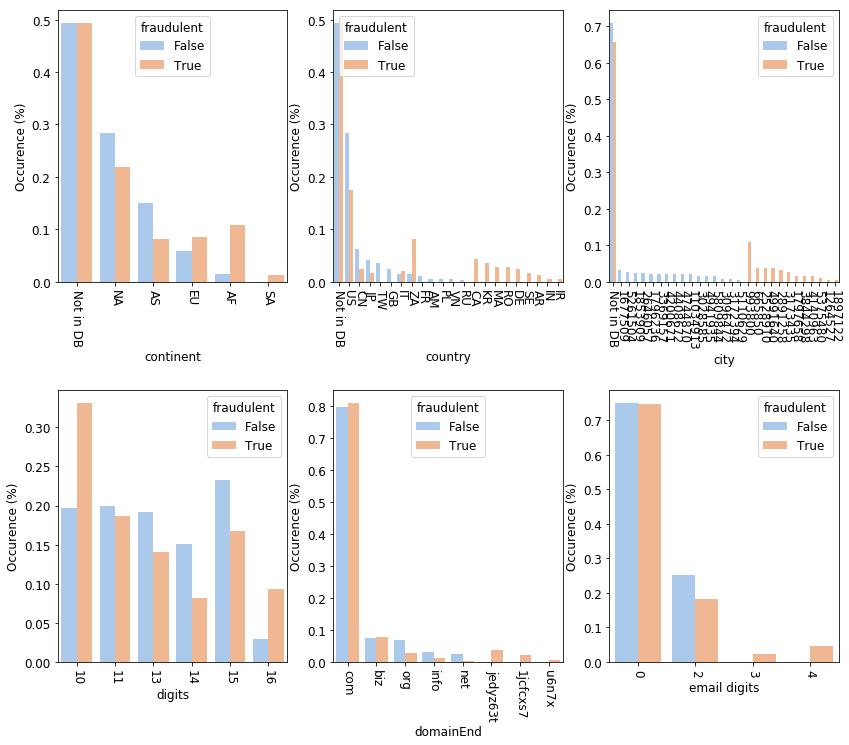

In [384]:
# Text Data Visualization
#
# Plotting some of our mined data to have a look

# Let's look at the features with a few categories, since they are easier to see
cont = fraudLabelComp('continent',iP)
count = fraudLabelComp('country',iP)
cit = fraudLabelComp('city',iP)
dig = fraudLabelComp('digits',phone)
dE = fraudLabelComp('domainEnd',email)
numb = fraudLabelComp('numbers',email)

# Make the plot of a few categorical features
fig,axes = plt.subplots(2,3,figsize=(14,12))

fraudLabelPlot(cont,0,0)
fraudLabelPlot(count,0,1)
fraudLabelPlot(cit,0,2)
fraudLabelPlot(dig,1,0)
fraudLabelPlot(dE,1,1)
fraudLabelPlot(numb,1,2)
plt.xlabel('email digits')

plt.subplots_adjust(hspace=0.4)
plt.subplots_adjust(wspace=0.2)
plt.show()

## More Feature Engineering

The categorical data has to be encoded into a numeric form for the algorithm.  
For this dataset a hashing encoder is utilized because this type of encoder will work better with decision tree and ensemble boosting methods, due to the increased capacity for a tree to take on more irregular shapes.

In [385]:
# Build our features 
# we need to encode our categorical data
# we will start with the most important categorical data first and see how large our dimensionality is getting

# There really aren't THAT many paymentIssuer or paymentProvider types, so this might be good for One-hot  
# or we can use a Hash encoder to keep the dimensionality down
# Since we might want to use a decision-tree algorithm, we will hash encode to avoid overfitting later

def addHashFeature(features_init,feature,dataFrame,n_comp):
    ce_hash = ce.HashingEncoder(cols=[feature],n_components=n_comp,return_df=True)
    features = pd.concat([ce_hash.fit_transform(dataFrame[feature],df['fraudulent']),features_init],axis=1)
    features.rename(columns = lambda x: x.replace('col',feature),inplace=True)
    return features

def addOneHotFeature(features_init,feature,dataFrame):
    ce_one_hot = ce.OneHotEncoder(cols=[feature])
    features = pd.concat([ce_one_hot.fit_transform(dataFrame[feature],df['fraudulent']),features_init],axis=1)
    return features

# Adding the fraudulent column first
features = pd.DataFrame(df['fraudulent'].apply(lambda x: int(x == True)))

# Add the features we want
# Decided to use Hash encoding mainly, since this turns out to be better for a lot of decision algorithms
# want to minimize collisions since cardinality is relatively low
features = addHashFeature(features,'paymentMethodIssuer',df,11)
features = addHashFeature(features,'paymentMethodProvider',df,10)
features = addHashFeature(features,'orderState',df,3)
features = addHashFeature(features,'paymentMethodType',df,4)

features = addHashFeature(features,'country',iP,30)
features = addHashFeature(features,'city',iP,22)
features = addHashFeature(features,'continent',iP,6)
features = addHashFeature(features,'pc',iP,25)
features = addHashFeature(features,'long',iP,44)
features = addHashFeature(features,'lat',iP,44)

features = addHashFeature(features,'countryCode',phone,99)
features = addHashFeature(features,'areaCode',phone,114)
features = addHashFeature(features,'digits',phone,6)

features = addHashFeature(features,'domainEnd',email,8)
features = addHashFeature(features,'domainStart',email,64)
features = addHashFeature(features,'chars',email,21)
features = addHashFeature(features,'numbers',email,4)

features = addHashFeature(features,'billState',billAndShip,55)
features = addHashFeature(features,'shipState',billAndShip,62)

# Deal with boolean data
features = pd.concat([df['paymentMethodRegistrationFailure'].apply(lambda x: int(x)),features],axis=1)
features = pd.concat([iP['IPv6'].apply(lambda x: int(x)),features],axis=1)
features = pd.concat([billAndShip['equal'].apply(lambda x: int(x)),features],axis=1)
features = pd.concat([phone['ext'].apply(lambda x: int(x)),features],axis=1)
features = pd.concat([df['transactionFailed'].apply(lambda x: int(x)),features],axis=1)

# Rescale transactionAmount
scaler = RobustScaler() # for the outliers
tA = pd.DataFrame(scaler.fit_transform(df[['transactionAmount','fraudulent']]))
features = pd.concat([tA[0],features],axis=1)
features.rename(columns = {features.columns[0]: 'transactionAmount'},inplace=True)

features.head()

,transactionAmount,transactionFailed,ext,equal,IPv6,paymentMethodRegistrationFailure,shipState_0,shipState_1,shipState_2,shipState_3,shipState_4,shipState_5,shipState_6,shipState_7,shipState_8,shipState_9,shipState_10,shipState_11,shipState_12,shipState_13,shipState_14,shipState_15,shipState_16,shipState_17,shipState_18,shipState_19,shipState_20,shipState_21,shipState_22,shipState_23,shipState_24,shipState_25,shipState_26,shipState_27,shipState_28,shipState_29,shipState_30,shipState_31,shipState_32,shipState_33,...,country_19,country_20,country_21,country_22,country_23,country_24,country_25,country_26,country_27,country_28,country_29,paymentMethodType_0,paymentMethodType_1,paymentMethodType_2,paymentMethodType_3,orderState_0,orderState_1,orderState_2,paymentMethodProvider_0,paymentMethodProvider_1,paymentMethodProvider_2,paymentMethodProvider_3,paymentMethodProvider_4,paymentMethodProvider_5,paymentMethodProvider_6,paymentMethodProvider_7,paymentMethodProvider_8,paymentMethodProvider_9,paymentMethodIssuer_0,paymentMethodIssuer_1,paymentMethodIssuer_2,paymentMethodIssuer_3,paymentMethodIssuer_4,paymentMethodIssuer_5,paymentMethodIssuer_6,paymentMethodIssuer_7,paymentMethodIssuer_8,paymentMethodIssuer_9,paymentMethodIssuer_10,fraudulent
0,-0.666667,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,-0.333333,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0.458333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
3,-0.458333,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
4,0.375000,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1


## Model Construction

Below, several classification models are tested using a cross-validation strategy to predict whether a transaction is fraudulent.  
  
The Gradient Boosting Classifier is identified as the best model.  
  
Next steps may be to tune the hyperparameters of the model to improve accuracy, however, it may be more prudent to mine more features from the dataset before the model is fine tuned. 

In [386]:
# Model Time!!
# 
# We should be a bit wary of overfitting to a fraudulent customer, 
# since we have duplicated the customer data for each transaction


# Define our x and y sets for modeling 
x = features.drop(['fraudulent'],axis=1)
y = features['fraudulent']

# Define cross validation strategy: f1 or F measure (to balance precision and recall)
def f1_cv(model,x,y):
    f1 = np.sqrt(cross_val_score(model, x, y, scoring="f1", cv=5))
    return f1

In [387]:
# Selection of models to try
models = [
    KNeighborsClassifier(3),
    NuSVC(probability=True, gamma = 'scale'),
    DecisionTreeClassifier(),
    RandomForestClassifier(max_leaf_nodes = 25),
    AdaBoostClassifier(n_estimators = 100),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]

names = ["KNN", "NSVC", "DTC", "RFC", "ABC", "GBC", "GNB", "LDA", "QDA"]

In [388]:
for name, model in zip(names, models):
    score = f1_cv(model, x, y)
    print("{}: {:.6f}, {:.4f}".format(name,score.mean(),score.std()))

KNN: 0.714590, 0.0358
NSVC: 0.668952, 0.0438
DTC: 0.745709, 0.0740
RFC: 0.701135, 0.0553
ABC: 0.730715, 0.0401
GBC: 0.806241, 0.0410
GNB: 0.656914, 0.1088
LDA: 0.691216, 0.0490
QDA: 0.672745, 0.0476


In [389]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2)

gbc = GradientBoostingClassifier()
gbc.fit(x_train,y_train);

### Feature Importance

Below the feature importance is visualized according to the Gradient Boosting Classifier. For simplicity, only the 20 most important features are shown.  

The transaction amount is clearly the most important feature, followed by various instances of the payment method issuer and city. This roughly aligns with earlier qualitative observations in the data, though it is more difficult to ascertain the exact nature of the features due to the hashing encoding method.  
  
Lastly, it would actually be more prudent to measure feature importance by permuting the data of each feature and measuring the reduced (or improved) performance of the model, but the algorithm attribute provides a more simple first look.

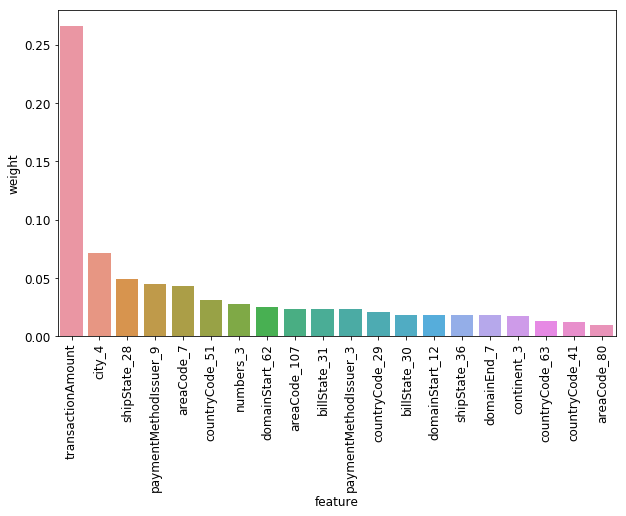

In [390]:
# Let's look at the important features according to gbc

fimportance = pd.DataFrame(gbc.feature_importances_)
fimportance['feature'] = x.columns
fimportance.rename({fimportance.columns[0]:  'value'})
fimportance.sort_values(by = fimportance.columns[0],ascending=False,inplace=True)
fig,ax = plt.subplots(figsize = [10,6])
sns.barplot(x = fimportance.iloc[:20,1], y = fimportance.iloc[:20,0])
ax.set_xticklabels(fimportance.iloc[:20,1], rotation = 90)
plt.ylabel('weight')
plt.show()

## Data Visualization: Results

The confusion matrix is plotted below. The upper left and lower right numbers indicate the percentage of the time the model predicts either True when the customer is fraudulent and False when the customer is not fraudulent. The lower left indcates how often the model predicts False when the customer is fraudulent (an incorrect prediction) and the upper right indicates how often the model predicts True when the customer is not fraudulent (the other incorrect prediction).
  
As can be seen in the confusion matrix, the model does well at predicting customers who are not fraudulent, and fairly well at predicting customers who are fraudulent. It is also very good at not predicting false postives, that is predicting customers to be fraudulent when in fact they are not. The drawback is that it does not minimize the number of true fraudulent customers that it predicts as being legitimate.  
  
In a future model, it would probably be prudent to choose a different score than F1, in order to minimize the number of true fraudulent customers that sneak through the algorithm, as these customers tend to be the most expensive for a business.

F-Score:  0.8686868686868687
Normalized confusion matrix
[[0.97 0.03]
 [0.2  0.8 ]]


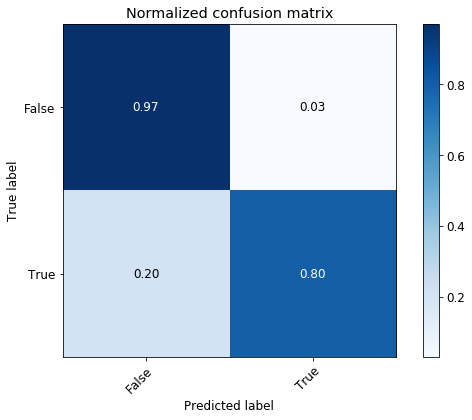

In [415]:
y_pred = gbc.predict(x_test)
print('F-Score: ', f1_score(y_test,y_pred))

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = np.array([0,1])
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize = [8,6])
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=['False','True'], yticklabels=['False','True'],
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=['False','True'], normalize=True,
                      title='Normalized confusion matrix')
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

plt.show()

## Preliminary Conclusions

 - The Gradient Boosting Classifier has been identified as a good algorithm with with which to model this dataset.
 - The model can reliably identify fraudulent customers 80% of the time. 
 - The model can reliably identify legitimate customers 97% of the time.
 - The transaction amount is the most important feature in this model.

## Extensions
 - The data could be further mined for features.
 - The model hyperparameters could be fine-tuned to imrove the accuracy.
 - The scoring on the model could be adjusted to reduce false negatives.
 - Different visualization techniques could be used to visualize different aspects of the model and datsets.